In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import copy

import matplotlib.pyplot as plt

In [ ]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')
data = data[:,1:]
dataNorm = data / np.max(data)
dataT = torch.tensor( dataNorm ).float()

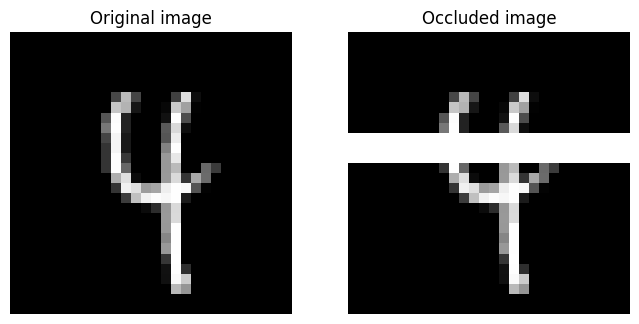

In [ ]:
img = dataT[12345,:].view(28,28)
occluded = copy.deepcopy( img )
occluded[10:13,:] = 1
fig,ax = plt.subplots(1,2,figsize=(8,5))
ax[0].imshow(img,cmap='gray')
ax[0].set_title('Original image')
ax[0].axis('off')
ax[1].imshow(occluded,cmap='gray')
ax[1].set_title('Occluded image')
ax[1].axis('off')
plt.show()

In [ ]:
def createTheMNISTAE():
  class Autoencoder(nn.Module):
    def __init__(self):
      super().__init__()
      self.input = nn.Linear(784,128)
      self.encoder = nn.Linear(128,50)
      self.latent = nn.Linear(50,128)
      self.decoder = nn.Linear(128,784)
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.encoder(x) )
      x = F.relu( self.latent(x) )
      y = torch.sigmoid( self.decoder(x) )
      return y

  autoencoder = Autoencoder()
  lossfun = nn.MSELoss()
  optimizer = torch.optim.Adam(autoencoder.parameters(),lr=.001)
  return autoencoder,lossfun,optimizer

In [ ]:
def function2trainTheModel():
  epochs = 5
  autoencoder,lossfun,optimizer = createTheMNISTAE()
  losses = []
  batchsize  = 32
  numBatches = int(dataT.shape[0]/batchsize)
  for epoch in range(epochs):
    randidx = np.random.permutation(dataT.shape[0]).astype(int)
    for batchi in range(numBatches):
      samps2use = range((batchi-1)*batchsize,batchi*batchsize)
      X = dataT[randidx[samps2use],:]
      yHat = autoencoder(X)
      loss = lossfun(yHat,X)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      losses.append( loss.item() )
  return losses,autoencoder

Final loss: 0.0131


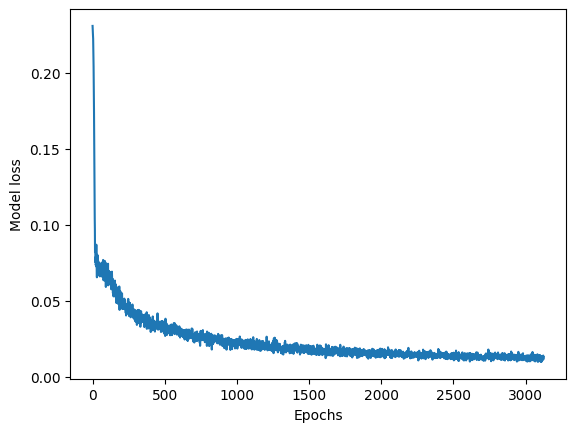

In [ ]:
losses,autoencoder = function2trainTheModel()
print(f'Final loss: {losses[-1]:.4f}')
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.show()

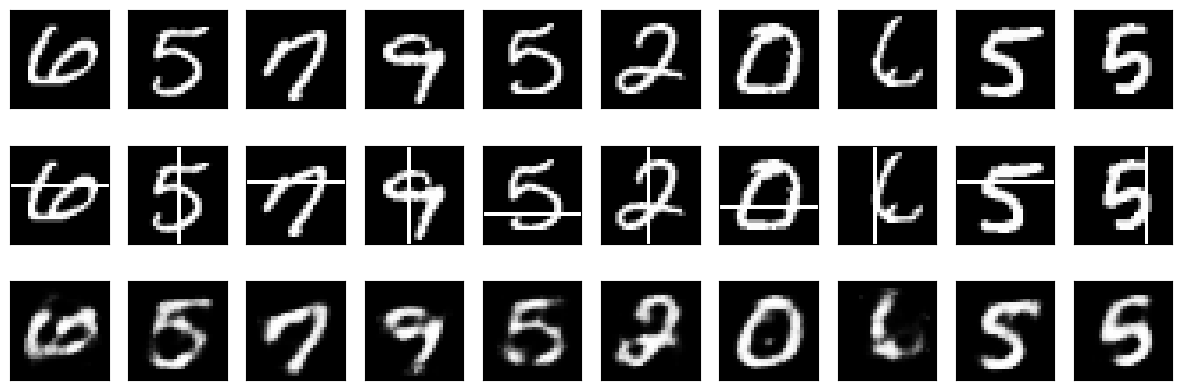

In [ ]:
X = copy.deepcopy( dataT[:10,:] )
for i in range(X.shape[0]):
  img = X[i,:].view(28,28)
  startloc = np.random.choice(range(10,21))
  if i%2==0: # even -> horizontal occlusion
    img[startloc:startloc+1,:] = 1
  else:      # odd -> vertical occlusion
    img[:,startloc:startloc+1] = 1

deOccluded = autoencoder(X)
fig,axs = plt.subplots(3,10,figsize=(15,5))

for i in range(10):
  axs[0,i].imshow(dataT[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[2,i].imshow(deOccluded[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  axs[2,i].set_xticks([]), axs[2,i].set_yticks([])

plt.show()

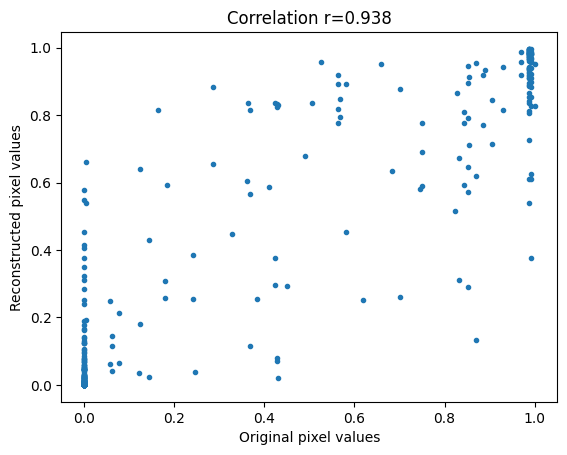

In [ ]:
inOutCorr = np.corrcoef(dataT[9,:].detach(),deOccluded[9,:].detach())

plt.plot(dataT[9,:].detach(),deOccluded[9,:].detach(),'.')
plt.xlabel('Original pixel values')
plt.ylabel('Reconstructed pixel values')
plt.title(f'Correlation r={ inOutCorr[0,1] :.3f}')
plt.show()

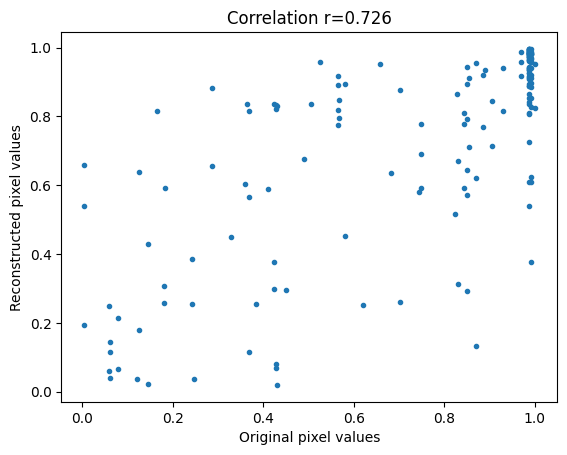

In [ ]:
orig  = dataT[9,:].detach()
recon = deOccluded[9,:].detach()
tol = 1e-4
nonzeropixels = (orig>tol) & (recon>tol)
inOutCorr = np.corrcoef(orig[nonzeropixels],recon[nonzeropixels])

plt.plot(orig[nonzeropixels],recon[nonzeropixels],'.')
plt.xlabel('Original pixel values')
plt.ylabel('Reconstructed pixel values')
plt.title(f'Correlation r={ inOutCorr[0,1] :.3f}')
plt.show()